# Road type data to area of prediction

This notebooks integrates proximity to different road types to the area of prediction

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import rasterio
import distancerasters as dr

from joblib import Parallel, delayed
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import aup

## Data download/read and preprocessing

### Area of prediction with variables

In [2]:
aop_gdf = gpd.read_file('../../data/processed/prediccion_uso_suelo/test/area_of_prediction_env.gpkg')
print(aop_gdf.shape)
aop_gdf.head(2)

(88061, 32)


,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,pobtot,...,pct_servicios,pct_comercio,pct_salud,pct_educacion,pct_gobierno,pct_industria,temperature_mean_diff,ndvi_mean,ndmi_diff,geometry
0,Sin dato,67.279056,75GRMGQW+89PG,1412000011206018,12.438638,278416.454431,67.279056,0.000242,0.184881,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.787026,0.084339,0.045966,"MULTIPOLYGON (((2349152.724 965335.704, 234914..."
1,Sin dato,45.355545,75GRMGQW+8CFP,1412000011206018,4.482118,278416.454431,45.355545,0.000163,0.098822,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.649216,0.109751,0.045719,"MULTIPOLYGON (((2349168.91 965335.176, 2349157..."


### Area of analysis

In [3]:
aoa_gdf = gpd.read_file("../../data/processed/prediccion_uso_suelo/Distrito_Zona5.geojson")
aoa_gdf = aoa_gdf.to_crs("EPSG:4326")
print(aoa_gdf.shape)
aoa_gdf.head(2)

(1, 4)


,id,area,perimeter,geometry
0,0,3.456908e+07,22034.335455,"POLYGON ((-103.44075 20.65239, -103.44091 20.6..."


### Edges

In [4]:
schema = "osmnx"
table = "edges_osmnx_23_line"

edges = aup.gdf_from_polygon(aoa_gdf, schema, table)
print(edges.shape)
edges.head(2)

(18247, 19)


,osmid,v,u,key,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,city
0,1240183945,1479737807,1197631449,0,False,4,Avenida Ludwig Van Beethoven,tertiary,None,223.407,"LINESTRING (-103.42764 20.66889, -103.42973 20...",None,None,None,None,None,None,None,Guadalajara
1,154534196,1617317997,1197631449,0,True,None,Calle Ingenieros,residential,None,95.417,"LINESTRING (-103.42764 20.66889, -103.42761 20...",None,None,None,None,None,None,None,Guadalajara


#### Road type processing

Transform lists stored as strings to list

In [5]:
from ast import literal_eval

In [6]:
def check_for_lists(val):
    try:
        val = literal_eval(val)
        return val
    except:
        return val

In [7]:
edges['highway'] = edges.highway.apply(lambda row: check_for_lists(row))

In [8]:
edges.loc[edges.highway.map(lambda x: 
                            isinstance(x, list)),'highway'] = edges.loc[
    edges.highway.map(lambda x: isinstance(x, list))].apply(
        lambda row: row['highway'][0], axis=1)

Check process

In [9]:
len(edges.loc[edges.highway.map(lambda x: 
                            isinstance(x, list))])

0

#### Remove link sections

In [10]:
edges.loc[edges['highway'].str.contains(
    "_link"),'highway'] = edges[edges['highway'].str.contains(
    "_link")].highway.apply(lambda x: x.replace('_link',''))

Check result

In [11]:
len(edges.loc[edges['highway'].str.contains(
    "_link"),'highway'])

0

In [12]:
edges.highway.unique()

array(['tertiary', 'residential', 'secondary', 'footway', 'path',
       'service', 'living_street', 'primary', 'trunk', 'pedestrian',
       'cycleway', 'unclassified', 'motorway', 'steps'], dtype=object)

## Road type proximity to area of analysis

In [13]:
edges = edges.to_crs("EPSG:4326")
aop_gdf = aop_gdf.to_crs("EPSG:4326")

In [14]:
pixel_size = 0.00023 # 0.00023° -> 25m

In [15]:
output_dir = '../../data/processed/prediccion_uso_suelo/test/prox_vialidades/'

In [16]:
if 'fid' not in list(aop_gdf.columns):
    aop_gdf = aop_gdf.reset_index().rename(columns={'index':'fid'})

In [17]:
# define bounds according to area of prediction
bounds = []
for c in aop_gdf.bounds:
    if 'min' in c:
        bounds.append(aop_gdf.bounds[c].min().item()-0.05)
    else:
        bounds.append(aop_gdf.bounds[c].max().item()+0.05)
bounds = tuple(bounds)
bounds

(-103.50519038008062,
 20.598380799956576,
 -103.34823173860825,
 20.77437984965573)

In [18]:
parallel_processing = True

In [19]:
def raster_conditional(rarray):
    return (rarray == 1)

In [20]:
def road_type_to_area_of_prediction(aop_road, edges, road_type, pxiel_size, bounds, output_dir):
    
    edges_road_type = edges.loc[edges.highway==road_type].copy()

    rv_array, affine = dr.rasterize(edges_road_type, pixel_size=pixel_size,
                                bounds=bounds, 
                                output=output_dir+f"{road_type}_rasterized.tif")

    # generate distance array and output to geotiff
    my_dr = dr.DistanceRaster(rv_array, affine=affine,
                          output_path=output_dir+f"{road_type}_distance.tif",
                          conditional=raster_conditional)

    raster_distance = rasterio.open(output_dir+f"{road_type}_distance.tif")

    aop_road[road_type+'_distance'] = aop_road.geometry.apply(
                lambda geom: aup.clean_mask(geom, raster_distance)).apply(np.ma.mean)

    aop_road = aop_road[['fid',road_type+'_distance']].copy()

    return aop_road


In [21]:
if parallel_processing:
    road_types = edges.highway.unique()

    results = Parallel(n_jobs=20, verbose=3)(
        delayed(road_type_to_area_of_prediction)(
            aop_gdf, edges, road_type, pixel_size, bounds, output_dir)
        for road_type in tqdm(road_types, desc="Processing roads")
    )

    for results_df in results:
        aop_gdf = aop_gdf.merge(results_df, on='fid', how='left')
        
print("Processing complete!")

Processing roads:   0%|      | 0/14 [00:00<?, ?it/s][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
Processing roads: 100%|█| 14/14 [00:00<00:00, 10670.
[Parallel(n_jobs=20)]: Done   5 out of  14 | elapsed:   42.0s remaining:  1.3min
[Parallel(n_jobs=20)]: Done  10 out of  14 | elapsed:   44.0s remaining:   17.6s
[Parallel(n_jobs=20)]: Done  14 out of  14 | elapsed:   45.3s finished


Processing complete!


<Axes: >

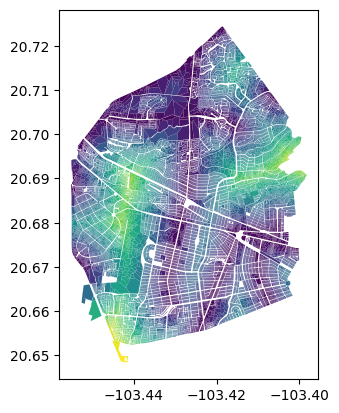

In [22]:
aop_gdf.plot('secondary_distance')

In [23]:
print(aop_gdf.shape)
aop_gdf.head(4)

(88061, 47)


,fid,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,...,path_distance,service_distance,living_street_distance,primary_distance,trunk_distance,pedestrian_distance,cycleway_distance,unclassified_distance,motorway_distance,steps_distance
0,0,Sin dato,67.279056,75GRMGQW+89PG,1412000011206018,12.438638,278416.454431,67.279056,0.000242,0.184881,...,1581.662275,11.962829,51.20766,3329.005414,87.628973,2935.411316,1968.027137,673.709507,374.060135,1584.676445
1,1,Sin dato,45.355545,75GRMGQW+8CFP,1412000011206018,4.482118,278416.454431,45.355545,0.000163,0.098822,...,1581.662275,11.962829,51.20766,3329.005414,87.628973,2935.411316,1968.027137,673.709507,374.060135,1584.676445
2,2,Sin dato,18.488100,75GRMGQW+8CHQ,1412000011206018,4.482118,278416.454431,18.488100,0.000066,0.242433,...,1571.799399,23.925657,51.20766,3326.382605,99.060846,2933.314590,1960.536593,675.621361,377.503315,1573.568150
3,3,Sin dato,4.936089,75GRMGQW+8GCG,1412000011206018,42.992618,278416.454431,4.936089,0.000018,8.709855,...,1561.995592,24.764744,51.20766,3323.841849,110.696135,2931.312591,1953.135493,677.943478,381.628189,1562.485278


## Save data

In [24]:
aop_gdf.to_file('../../data/processed/prediccion_uso_suelo/test/area_of_prediction_roads.gpkg')